## LSTM Encoder-Decoder for univariate input for sequence output

In [1]:
# coding: utf-8
# !/usr/bin/env python3
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, RepeatVector
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras import optimizers

In [2]:
# load data, Instead of doing all the pre-processing, using the saved numpy arrays
train_scaled = np.load("./hourly_models/train_scaled_48_to_48.npy")
eval_scaled = np.load("./hourly_models/eval_scaled_48_to_48.npy")
test_scaled = np.load("./hourly_models/test_scaled_48_to_48.npy")
print("Training scaled data shape: ", train_scaled.shape)
print("Evaluation scaled data shape: ", eval_scaled.shape)
print("Test scaled data shape: ", test_scaled.shape)

Training scaled data shape:  (33723, 8)
Evaluation scaled data shape:  (768, 8)
Test scaled data shape:  (96, 8)


In [3]:
# Load the scalar
scalar = joblib.load("./hourly_models/min_max_all_feat_48_to_48.pkl")

### Preparing Input & Output dimensions

In [4]:
def get_X_y(data, n_in, n_out):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_in
        out_end = in_end + n_out
        # ensuring that we have enough data for this instance
        if out_end <= len(data):
            # need only 1 feature
            x_input = data[in_start:in_end, 0]
            # reshaping [timestemps, features]
            x_input = x_input.reshape((len(x_input), 1))
            # it will give [samples, timestemps, features]
            X.append(x_input)
            # [samples, output]
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

In [5]:
# the model will follow same startegy as model 1 (univariate to vector output)
n_input = 48
n_output = 48
X_train, y_train = get_X_y(data=train_scaled, n_in=n_input, n_out=n_output)
X_eval, y_eval = get_X_y(data=eval_scaled, n_in=n_input, n_out=n_output)
X_test, y_test = get_X_y(data=test_scaled, n_in=n_input, n_out=n_output)
print("Train X shape: ", X_train.shape)
print("Train y shape: ", y_train.shape)
print("Evaluation X shape: ", X_eval.shape)
print("Evaluation y shape: ", y_eval.shape)
print("Test X shape: ", X_test.shape)
print("Test y shape: ", y_test.shape)

Train X shape:  (33628, 48, 1)
Train y shape:  (33628, 48)
Evaluation X shape:  (673, 48, 1)
Evaluation y shape:  (673, 48)
Test X shape:  (1, 48, 1)
Test y shape:  (1, 48)


### Define and build models
**Strategy is same as previous model 1, but here instead using univariate to vector output architecture will use univariate encoder-decoder for sequence output**
_Also in previous model we didn't perform few steps like saving the best fit model_

In [6]:
# seeding the random number generation
seed = 101
np.random.seed(seed)
tf.set_random_seed(seed)
# defining parameters
learning_rate = 0.01
# because of CPU contraints, will run it for lesser number of epochs
epochs = 30
batch_size = 16
verbose = 2
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

# reshape output into [samples, timesteps, features] (unlike to the other model this model needs the shape to be 3 dimensional)
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))

# define model
model = Sequential()
model.add(LSTM(100, activation="relu", input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(n_outputs))
model.add(LSTM(100, activation="relu", return_sequences=True))
model.add(TimeDistributed(Dense(50, activation="relu")))
model.add(TimeDistributed(Dense(1)))
# create optimizer unit to define learning rate
optmzr = optimizers.Adam(lr=learning_rate)
# compile the model
model.compile(loss="mse", optimizer=optmzr,  metrics=["mse"])
tf.logging.set_verbosity(tf.logging.ERROR)

# model checkpoint
filepath="./hourly_models/model_2/weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", verbose=verbose, save_best_only=True, mode="min")
callbacks_list = [checkpoint]

# defining custom saver
# class CustomSaver(Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if epoch == 2:  # or save after some epoch, each k-th epoch etc.
#             self.model.save("model_{}.hd5".format(epoch))
# saver = CustomSaver()

# fit network (we have separate validation set, using 10 % from the train data to best best fit)
start = datetime.datetime.now()
model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, verbose=verbose)
end = datetime.datetime.now()
print("Model training started at: ", start, " & ended at: ", end)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 30265 samples, validate on 3363 samples
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.01009, saving model to ./hourly_models/model_2/weights_best.hdf5
 - 192s - loss: 9007375.5440 - mean_squared_error: 9007375.0000 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 2/30

Epoch 00002: val_loss did not improve from 0.01009
 - 193s - loss: 0.0192 - mean_squared_error: 0.0192 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 3/30

Epoch 00003: val_loss improved from 0.01009 to 0.00971, saving model to ./hourly_models/model_2/weights_best.hdf5
 - 195s - loss: 0.0189 - mean_squared_error: 0.0189 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 4/30

Epoch 00004: val_loss did not improve from 0.00971
 - 197s - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 5/30

Epoch 00005: val_

### It took me more than 1.5 hours train this model.

In [7]:
# Saving the model for later use
# save model to JSON
model_json = model.to_json()
with open("./hourly_models/model_2/model.json", "w") as json_file:
    json_file.write(model_json)
# we are not necessarily need to save weights, because already saving the best weights
# but though saving the last trained weights
# serialize weights to HDF5
model.save_weights("./hourly_models/model_2/last_weights.h5")

In [8]:
model.history.history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

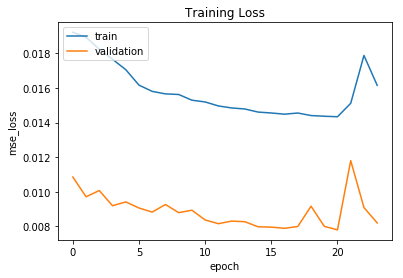

In [13]:
plt.plot(model.history.history["loss"][1:])
plt.plot(model.history.history["val_loss"][1:])
plt.title("Training Loss")
plt.ylabel("mse_loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc='upper left');

**We can see validation error is lesser than training error, it can be because of while doing validation split it takes last number % of data. It doesn't follow splitting as I mentioned above so that sequence are purely disconnected. Here first 47 instance sequence was already visible to the trainer, so may be giving a better fit. What we can try is, taking 10% for the validation, will increase to some other higher % so that the first 47 instances can't influence much the overall calculation.**

### Few problems might occured in the training of above Network
**From epoch 26, we can see that the network is no longer learning, the loss become NaN**    
**Possible explanations and resolutions:**
1. Exploding gradients: large updates to weights during training can cause a numerical overflow or underflow. The weights can take on the value of an “NaN” or “Inf” when they overflow or underflow.
2. Can happen because of poor choice of learning rate, loss function or data preparation. In this case, mean square error is easily differentiable loss. We have scaled our data. So it can be the **Learning Rate** is high. Our choice is 0.01, we should try reducing it.
3. As a solution we can try gradient norm scaling: This involves changing the derivatives of the loss function to have a given vector norm when the L2 vector norm (sum of the squared values) of the gradient vector exceeds a threshold value. Eg: Let we have a norm of 1.0, meaning that if the vector norm for a gradient exceeds 1.0, then the values in the vector will be rescaled so that the norm of the vector equals 1.0.
4. Also can try gradient value clipping: This involves clipping the derivatives of the loss function to have a given value if a gradient value is less than a negative threshold or more than the positive threshold.Eg: we have a norm of 0.5, meaning that if a gradient value was less than -0.5, it is set to -0.5 and if it is more than 0.5, then it will be set to 0.5.

### Instead of tuning the model, for the time being will just go ahead with latest best model. And evaluate it.

In [14]:
X_eval.shape

(673, 48, 1)

In [17]:
# import the best model
# load json and create model
with open("./hourly_models/model_2/model.json", "r") as json_file:
    model_json = json_file.read()
latest_best_model = model_from_json(model_json)
# load weights into the model
latest_best_model.load_weights("./hourly_models/model_2/weights_best.hdf5")

In [18]:
predictions = []
for arr in X_eval:
    # here array shape is (n_input_timestemps, n_features)
    yhat = latest_best_model.predict(arr.reshape(1, n_input, 1))
    predictions.append(yhat)
predictions = np.array(predictions)

In [19]:
print(predictions.shape)
print(y_eval.shape)

(673, 1, 48, 1)
(673, 48)


In [20]:
# we can check how far they lie
scores = list()
# calculate an RMSE score for each hour
# make the prediction shape as eval shape
pred = predictions.reshape(predictions.shape[0], predictions.shape[2])
#  0th index of scalar values will have details about global_active_power
mult_range = scalar.data_range_[0]
add_min = scalar.data_min_[0]
for i in range(y_eval.shape[1]):
    # convert to original scale, we have used MinMaxScalar
    y_eval_inverse = y_eval[:, i] * mult_range + add_min
    pred_inverse = pred[:, i] * mult_range + add_min
    # calculate mse
    mse = mean_squared_error(y_eval_inverse, pred_inverse)
    # calculate rmse
    rmse = np.sqrt(mse)
    # store
    scores.append(rmse)

Text(0,0.5,'Prediction Hours')

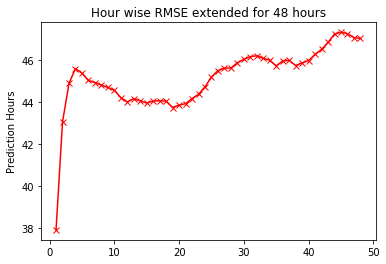

In [21]:
hours = np.arange(1,49)
plt.plot(hours, scores, marker='x', color="r")
plt.title("Hour wise RMSE extended for 48 hours")
plt.ylabel("RMSE global_active_power")
plt.ylabel("Prediction Hours")

### Very short-term prediction is better compared to long term predictions. Comparatively this model looks better.

In [22]:
# Checking overall RMSE
mult_range = scalar.data_range_[0]
add_min = scalar.data_min_[0]
overall_mse = mean_squared_error(y_eval.flatten() * mult_range + add_min, pred.flatten() * mult_range + add_min)
overall_rmse = np.sqrt(overall_mse)
print("Overall RMSE for 1 months evaluation period is: {:.2f}".format(overall_rmse))

Overall RMSE for 1 months evaluation period is: 45.18


### Prediction for last 48 hours

In [23]:
X_pred, y_pred = X_test, y_test
print("Pred X shape: ", X_pred.shape)
print("Pred y shape (in reality it won't be there): ", y_pred.shape)

Pred X shape:  (1, 48, 1)
Pred y shape (in reality it won't be there):  (1, 48)


In [24]:
# predict for next 48 hours
predictions = []
# looping so that we can have multiple prediction instances
for arr in X_pred:
    # here array shape is (n_input_timestemps, n_features)
    yhat = latest_best_model.predict(arr.reshape(1, 48, 1))
    predictions.append(yhat)
predictions = np.array(predictions)

In [25]:
predictions.shape

(1, 1, 48, 1)

In [26]:
# Convert to original scale
mult_range = scalar.data_range_[0]
add_min = scalar.data_min_[0]
# just looping so that we can generate multiple prediction instance
original_scale_pred = []
for p in predictions:
    inv_scale_pred = p.flatten() * mult_range + add_min
    original_scale_pred.append(inv_scale_pred)

In [28]:
original_scale_pred[0]

array([107.68484 ,  92.88744 ,  57.928375,  41.552574,  32.47532 ,
        27.600203,  24.725391,  27.868263,  36.69195 ,  59.710556,
        92.62095 , 104.500626,  97.541245,  91.83694 ,  91.83694 ,
        86.32468 ,  80.56918 ,  75.08442 ,  69.66311 ,  67.293594,
        80.31794 , 109.34136 , 132.38164 , 141.67157 , 131.32355 ,
        96.73796 ,  64.50194 ,  43.324055,  34.996647,  30.09396 ,
        27.070774,  27.717869,  34.12956 ,  50.754665,  86.51834 ,
       104.770775,  99.634445,  91.83694 ,  91.83694 ,  88.8415  ,
        82.80831 ,  77.38322 ,  71.45107 ,  68.661   ,  78.26791 ,
       102.84664 , 128.29117 , 139.53415 ], dtype=float32)

In [29]:
# Create a dataframe to share this (any other way)
df = pd.DataFrame({"local_time": pd.date_range(start="2010-11-24 21:00:00", end="2010-11-26 20:00:00", freq="H"), 
                   "global_active_power": original_scale_pred[0]})
df.set_index("local_time", inplace=True)

In [30]:
df.head()

,global_active_power
local_time,
2010-11-24 21:00:00,107.684837
2010-11-24 22:00:00,92.887444
2010-11-24 23:00:00,57.928375
2010-11-25 00:00:00,41.552574
2010-11-25 01:00:00,32.475319


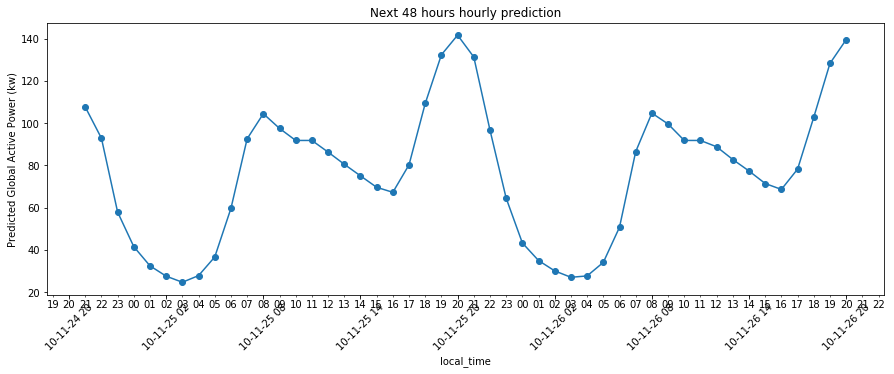

In [31]:
# Can share the visualtization also as a prediction results
fig, ax = plt.subplots(figsize=(15,5))
ax.plot("global_active_power", data=df, marker="o")
ax.set(xlabel="local_time", ylabel="Predicted Global Active Power (kw)",
       title="Next 48 hours hourly prediction")
ax.xaxis.set_major_formatter(DateFormatter("%y-%m-%d %H"))
ax.xaxis.set_minor_locator(HourLocator())
ax.xaxis.set_minor_formatter(DateFormatter("%H"))
plt.xticks(rotation=45);

### Compare Actual vs Predicted

In [32]:
df["actual_global_active_power"] = y_pred.flatten() * mult_range + add_min

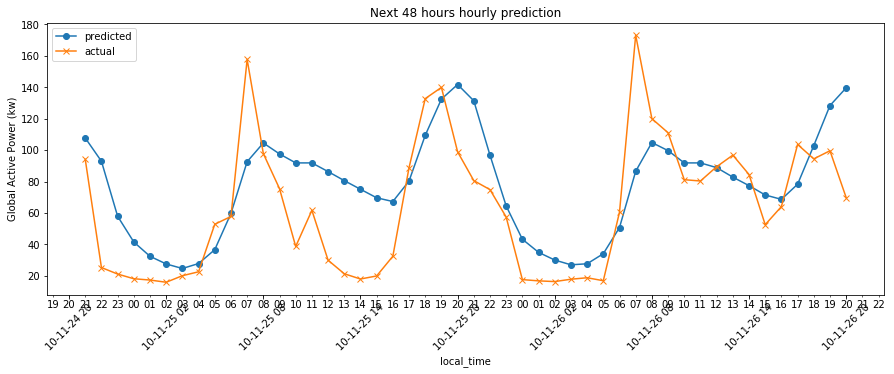

In [33]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot("global_active_power", data=df, marker="o")
ax.plot("actual_global_active_power", data=df, marker="x")
ax.set(xlabel="local_time", ylabel="Global Active Power (kw)",
       title="Next 48 hours hourly prediction")
ax.xaxis.set_major_formatter(DateFormatter("%y-%m-%d %H"))
ax.xaxis.set_minor_locator(HourLocator())
ax.xaxis.set_minor_formatter(DateFormatter("%H"))
plt.legend(["predicted", "actual"], loc='upper left')
plt.xticks(rotation=45);

### As compared to model 1, we can see that curve become little smoother. This model is trying better in generalizing the pattern compared to the previous model.